In [2]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path
# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import  Reshape , Conv1D, MaxPool1D, Flatten, Dropout, Dense,MaxPooling1D # importing CNN layers
from keras.models import Sequential #importing Sequential layer

feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

from google.colab import drive
drive.mount('/content/drive')

train='/content/drive/MyDrive/Projects_Done/VANET_IDS_CNN_LSTM/KDDTrain+.txt'
test='/content/drive/MyDrive/Projects_Done/VANET_IDS_CNN_LSTM/KDDTest-21.txt'
test21='/content/drive/MyDrive/Projects_Done/VANET_IDS_CNN_LSTM/KDDTest+.txt'
train_data=pd.read_csv(train,names=feature)
test_data=pd.read_csv(test,names=feature)
test_data21 = pd.read_csv(test21, names= feature)
data= pd.concat([train_data, test_data], ignore_index=True)
data





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137818,0,udp,domain_u,SF,43,43,0,0,0,0,...,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,normal,18
137819,0,tcp,http,SF,336,285,0,0,0,0,...,0.92,0.02,0.00,0.00,0.00,0.00,0.05,0.00,normal,18
137820,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.37,0.03,0.01,0.02,0.05,0.08,0.85,0.58,mscan,13
137821,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.19,0.03,0.01,0.04,0.00,0.00,0.88,1.00,mscan,15


In [3]:
# number of attack labels
data['label'].value_counts()
# Redistribute across common attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)
change_label(data)
# distribution of attack classes
data.label.value_counts()


# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)

# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df





In [4]:
from sklearn.decomposition import PCA

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data, numeric_col)

le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label

print(data.shape)
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)

data = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'], prefix="", prefix_sep="")
print(data.shape)

y_data = data['intrusion']
X_data = data.drop(labels=['intrusion'], axis=1)

print('X_data has shape:', X_data.shape, '\ny_data has shape:', y_data.shape)

pca = PCA(n_components=10)
X_data_pca = pca.fit_transform(X_data)
print(pca.components_)
col_names = X_data.columns
col_names = X_data.columns
features = []
for i in range(10):
    feature_name = "PC" + str(i + 1)
    feature = col_names[pca.components_[i].argmax()]
    features.append(feature)
    print("{}: {}".format(feature_name, feature))

X_train, X_test, y_train, y_test = train_test_split(X_data_pca, y_data, test_size=0.20, random_state=42)

print('X_train has shape:', X_train.shape, '\ny_train has shape:', y_train.shape)
print(X_train.shape, '\n', X_test.shape)


(137823, 44)
(137823, 43)
(137823, 124)
X_data has shape: (137823, 123) 
y_data has shape: (137823,)
[[ 1.58170747e-03 -7.23505440e-05  1.29825573e-04 ...  3.29771576e-04
  -1.59423990e-01  9.34784223e-04]
 [ 1.06962812e-01  6.79337748e-03  6.90723950e-03 ... -2.62971558e-04
  -5.62261768e-02 -2.24682533e-04]
 [ 8.17004223e-02  3.55651447e-03  3.25374341e-03 ...  8.96472556e-05
   1.87862323e-04  1.88431950e-04]
 ...
 [ 2.73067965e-01  6.28157080e-02  4.10734414e-02 ...  8.34859749e-04
   7.98613975e-02  4.23996665e-03]
 [ 5.23316971e-01  2.79966849e-01  1.50547142e-01 ...  1.26963831e-03
  -5.65336429e-02 -6.56657344e-04]
 [ 3.29485069e-01  1.59862860e-01  8.23509599e-02 ... -6.44368010e-04
  -5.00109745e-03  1.46255851e-03]]
PC1: dst_host_srv_serror_rate
PC2: srv_rerror_rate
PC3: num_root
PC4: difficulty
PC5: srv_count
PC6: is_guest_login
PC7: num_compromised
PC8: dst_host_diff_srv_rate
PC9: duration
PC10: duration
X_train has shape: (110258, 10) 
y_train has shape: (110258,)
(110258

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 128)               1

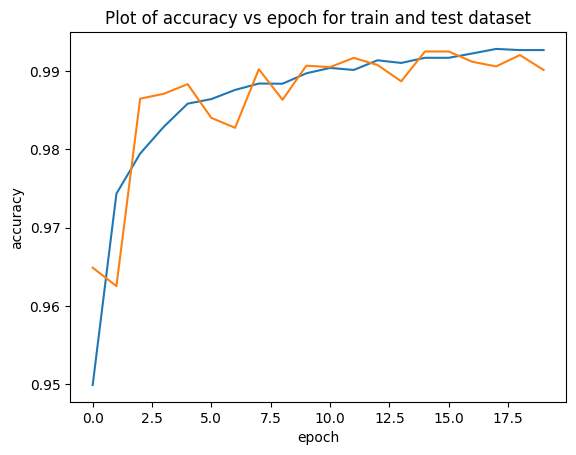

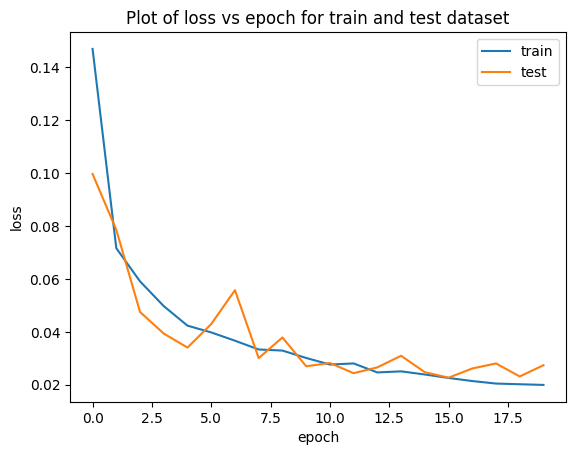

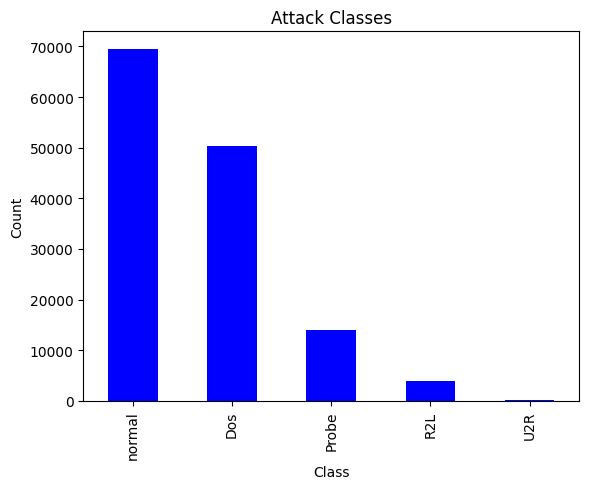

In [5]:

# Define the model architecture

from keras.layers import LSTM

model = Sequential() # initializing model
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(128))
model.add(Dense(units=50))

# output layer with softmax activation
model.add(Dense(units=5, activation='softmax'))

# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summary of model layers
model.summary()

# training the model on training dataset
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100 + (0.1)}%')

# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# count the number of samples for each attack class
attack_classes = label['label'].value_counts()

# plot a bar plot of attack classes
attack_classes.plot(kind="bar", color="blue")
plt.title("Attack Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

862/862 [==============================] - 5s 6ms/step


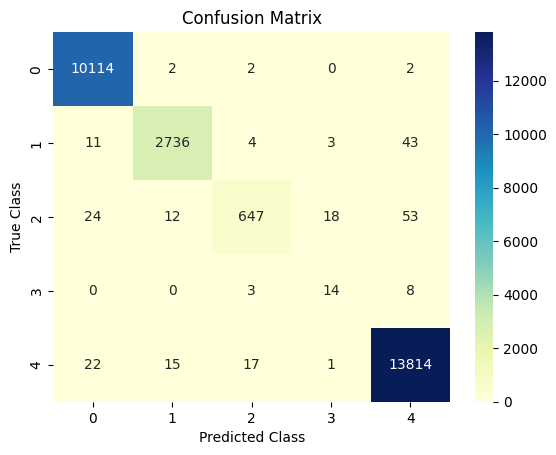

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Predict target attribute on testing dataset
y_pred = model.predict(X_test)
# Convert predictions to binary class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Check if y_test is one-hot encoded
if len(y_test.shape) > 1:
    y_true_labels = np.argmax(y_test, axis=1)
else:
    y_true_labels = y_test

# Calculate accuracy score
acc = accuracy_score(y_true_labels, y_pred_labels)
# Calculate F1 score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


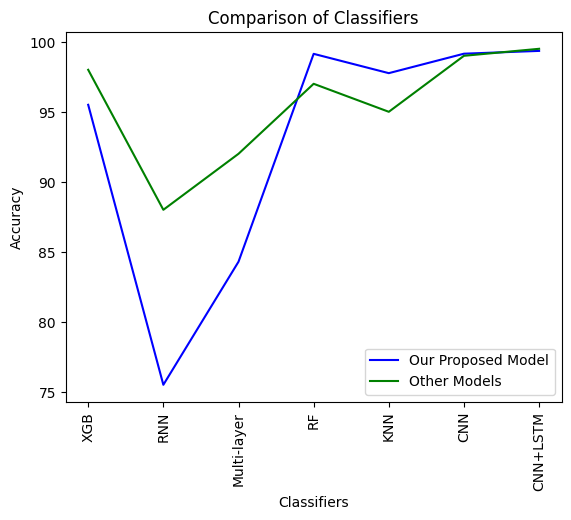

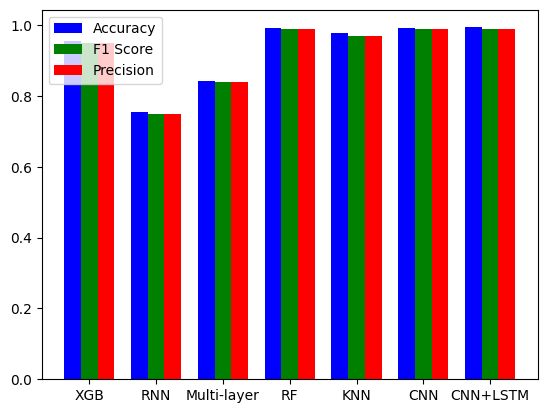

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data for line graph
x = [1, 2, 3, 4, 5, 6, 7]
y1 = [95.5, 75.5, 84.29, 99.14, 97.76, 99.15, 99.35]
y2 = [98, 88, 92, 97, 95, 99, 99.5]

# Data for bar graph
labels = ['XGB', 'RNN', 'Multi-layer', 'RF', 'KNN', 'CNN', 'CNN+LSTM']
accuracy = [0.955, 0.755, 0.8429, 0.9914, 0.9776, 0.9915, 0.9935]
f1_score = [0.95, 0.75, 0.84, 0.99, 0.97, 0.99, 0.99]
precision = [0.95, 0.75, 0.84, 0.99, 0.97, 0.99, 0.99]

# Line graph
plt.plot(x, y1, color='blue', label='Our Proposed Model')
plt.plot(x, y2, color='green', label='Other Models')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifiers')
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.show()

# Bar graph
x_pos = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos - width, accuracy, width, color='blue', label='Accuracy')
rects2 = ax.bar(x_pos, f1_score, width, color='green', label='F1 Score')
rects3 = ax.bar(x_pos + width, precision, width, color='red', label='Precision')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()
plt.show()
